In [2]:
import numpy as np
import pandas as pd
import util
import ml_alg
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = 'dataSets/training/'
test_path = "dataSets/testing_phase1/"

# Read data

In [11]:
volume_data = pd.read_csv(train_path + 'volume(table 6)_training.csv', header = 0, error_bad_lines=False)
weather_data = pd.read_csv(train_path + 'weather (table 7)_training.csv', header = 0, error_bad_lines=False)
trajectories = pd.read_csv(train_path + 'trajectories(table 5)_training.csv', header = 0, error_bad_lines=False)
route = pd.read_csv(train_path + 'routes (table 4).csv', header = 0, error_bad_lines=False)
links = pd.read_csv(train_path + 'links (table 3).csv', header = 0, error_bad_lines=False)

In [49]:
test_trajectories = pd.read_csv(test_path + 'trajectories(table 5)_test1.csv', header = 0, error_bad_lines=False)
test_volume_data = pd.read_csv(test_path + 'volume(table 6)_test1.csv', header = 0, error_bad_lines=False)
test_weather_data = pd.read_csv(test_path + 'weather (table 7)_test1.csv', header = 0, error_bad_lines=False)

In [12]:
volume_data.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2,0,1,0,NaN
1,2016-09-19 23:11:53,2,0,1,0,NaN
2,2016-09-19 23:13:54,2,0,1,0,NaN
3,2016-09-19 23:17:48,1,0,1,1,NaN
4,2016-09-19 23:16:07,2,0,1,0,NaN


### Check info

In [14]:
volume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543699 entries, 0 to 543698
Data columns (total 6 columns):
time             543699 non-null object
tollgate_id      543699 non-null int64
direction        543699 non-null int64
vehicle_model    543699 non-null int64
has_etc          543699 non-null int64
vehicle_type     212710 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 24.9+ MB


Only vehicle_type has NaN values(a lot). From the FAQ, we know the “vehicle_type” column describes the type of vehicles when they exit the highway (direction =1). That column would be NULL when a vehicle enters the highway (direction = 0).

In [33]:
volume_data[volume_data['vehicle_type'].isnull()][volume_data['direction'] == 1]

/Users/Solomon/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type


In [36]:
volume_data[volume_data['vehicle_type'].notnull()][volume_data['direction'] == 0]

/Users/Solomon/anaconda3/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type


Therefore, if vehicle_type is null, the direction must be 0. If direction is 1, the vehicle type is not null. Only vehicle_model, has_etc, vehicle_type can be features. They are all categorical features. The vehicle_type is 0(passenger vehicle) or 1(cargo vehicle). We should replace null to 2 which represents unknown. 

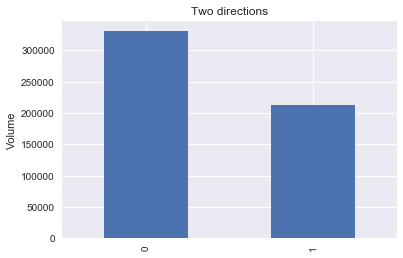

In [38]:
util.plot_feature_hist(volume_data['direction'], 'Volume', 'Two directions')

Direction: 0: entry, 1: exit. Entries much larger. This should because tollgate 2 only allows traffic entering the highway. 

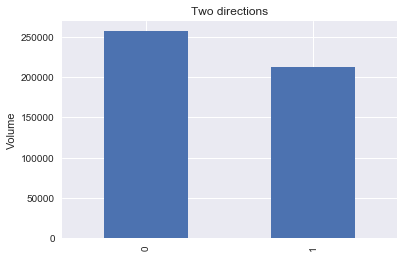

In [39]:
util.plot_feature_hist(volume_data[volume_data['tollgate_id'] != 2]['direction'], 'Volume', 'Two directions')

Much balanced but still entries larger. 

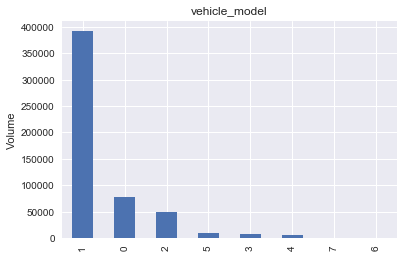

In [40]:
util.plot_feature_hist(volume_data['vehicle_model'], 'Volume', 'vehicle_model')

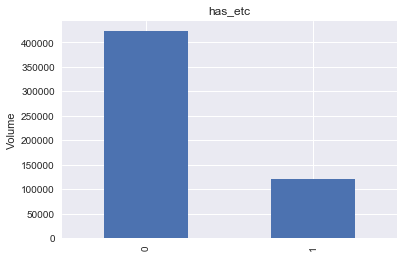

In [41]:
util.plot_feature_hist(volume_data['has_etc'], 'Volume', 'has_etc')

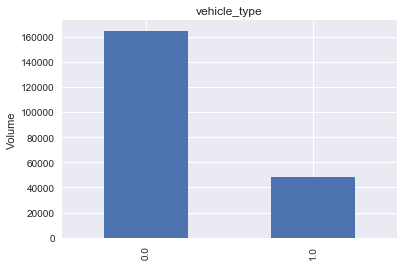

In [42]:
util.plot_feature_hist(volume_data['vehicle_type'], 'Volume', 'vehicle_type')

The number of passenger vehicle is much larger, and the number of vehicle with capacity 1 is much larger. 

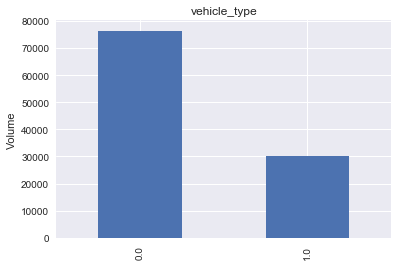

In [45]:
util.plot_feature_hist(volume_data[volume_data['tollgate_id'] ==1]['vehicle_type'], 'Volume', 'vehicle_type')

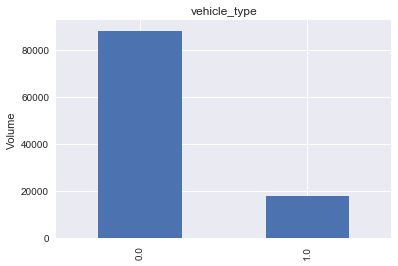

In [47]:
util.plot_feature_hist(volume_data[volume_data['tollgate_id'] ==3]['vehicle_type'], 'Volume', 'vehicle_type')

This illustrates that the distribution for different stations are different. 

In [50]:
test_volume_data.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-10-18 07:59:04,2,0,1,1,NaN
1,2016-10-18 07:59:31,2,0,1,1,NaN
2,2016-10-18 07:59:50,2,0,1,1,NaN
3,2016-10-18 07:32:33,3,0,1,1,NaN
4,2016-10-18 07:32:46,3,0,1,1,NaN


In [51]:
test_volume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29441 entries, 0 to 29440
Data columns (total 6 columns):
time             29441 non-null object
tollgate_id      29441 non-null int64
direction        29441 non-null int64
vehicle_model    29441 non-null int64
has_etc          29441 non-null int64
vehicle_type     12715 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.3+ MB


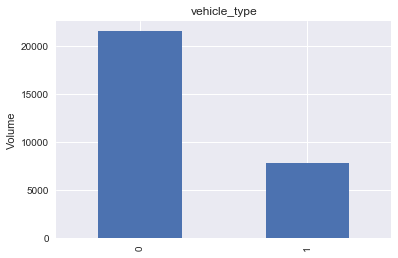

In [54]:
util.plot_feature_hist(test_volume_data['has_etc'], 'Volume', 'vehicle_type')

The distribution is similar to training data. 

In [55]:
weather_data.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-07-01,0,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
1,2016-07-01,3,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2,2016-07-01,6,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
3,2016-07-01,9,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
4,2016-07-01,12,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [57]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 9 columns):
date              782 non-null object
hour              782 non-null int64
pressure          782 non-null float64
sea_pressure      782 non-null float64
wind_direction    782 non-null float64
wind_speed        782 non-null float64
temperature       782 non-null float64
rel_humidity      782 non-null float64
precipitation     782 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 55.1+ KB


In [58]:
test_weather_data.head()

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
0,2016-10-18,0,1015.2,1020.3,62.0,2.1,20.5,87.0,0.0
1,2016-10-18,3,1014.5,1019.5,37.0,2.5,23.3,73.0,0.0
2,2016-10-18,6,1012.5,1017.5,128.0,1.6,23.4,73.0,0.0
3,2016-10-18,9,1013.0,1018.0,205.0,0.6,20.9,94.0,1.8
4,2016-10-18,12,1013.8,1018.8,106.0,1.5,20.5,94.0,0.5


In [59]:
weather_data.describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
count,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000,782.000000
mean,10.500000,1004.032353,1008.907545,10398.617647,2.315217,27.532992,74.253197,0.232353
std,6.866525,5.643326,5.729872,100572.980954,1.230320,4.977435,15.732717,1.453105
min,0.000000,993.400000,998.200000,0.000000,0.000000,14.100000,27.000000,0.000000
25%,6.000000,1000.000000,1004.800000,80.000000,1.500000,23.800000,63.000000,0.000000
50%,10.500000,1002.400000,1007.200000,190.000000,2.000000,27.700000,76.000000,0.000000
75%,15.000000,1007.575000,1012.575000,295.750000,2.900000,31.100000,88.000000,0.000000
max,21.000000,1018.400000,1023.500000,999017.000000,7.500000,39.400000,98.000000,27.200000


In [61]:
test_weather_data.describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,10.500000,1008.712500,1013.710714,162.678571,2.207143,21.191071,92.000000,0.451786
std,6.936072,3.520747,3.533357,121.204126,1.087592,1.134465,7.037562,0.827481
min,0.000000,999.400000,1004.300000,0.000000,0.500000,19.200000,68.000000,0.000000
25%,5.250000,1006.575000,1011.575000,81.750000,1.600000,20.500000,91.000000,0.000000
50%,10.500000,1008.950000,1013.950000,103.000000,2.000000,21.000000,94.500000,0.100000
75%,15.750000,1011.250000,1016.250000,323.500000,2.625000,21.700000,96.000000,0.350000
max,21.000000,1015.200000,1020.300000,357.000000,6.000000,24.500000,98.000000,3.300000


Wind_direction in training data has anomaly. A obvious trend is that in test data the humidity and precipitation are larger. Not sure if 27.200000 is outlier or not. 

In [63]:
weather_data[weather_data['wind_direction'] >= 500]

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
15,2016-07-02,21,1000.9,1005.8,999017.0,0.1,25.2,98.0,0.0
23,2016-07-03,21,1000.4,1005.3,999017.0,0.0,25.7,98.0,0.0
84,2016-07-11,12,994.8,999.6,999017.0,0.2,27.3,94.0,2.7
271,2016-08-03,21,1003.5,1008.3,999017.0,0.0,25.6,89.0,0.0
283,2016-08-05,9,1000.6,1005.4,999017.0,0.0,32.5,64.0,0.0
290,2016-08-06,6,999.0,1003.8,999017.0,0.0,28.1,88.0,2.0
654,2016-10-01,0,1009.4,1014.4,999017.0,0.1,22.3,93.0,0.0
763,2016-10-15,15,1013.9,1019.0,999017.0,0.0,19.8,97.0,0.0


In [73]:
weather_data[weather_data['precipitation'] >= 3.3]

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
11,2016-07-02,9,1001.9,1006.8,345.0,2.4,25.9,95.0,10.2
67,2016-07-09,9,997.9,1002.8,71.0,2.7,27.1,92.0,7.3
261,2016-08-02,15,1003.1,1007.9,310.0,3.1,24.5,94.0,4.8
262,2016-08-02,18,1002.5,1007.3,221.0,1.8,24.7,96.0,3.6
312,2016-08-09,0,1000.6,1005.5,18.0,1.0,25.4,95.0,14.2
411,2016-08-21,9,998.9,1003.7,348.0,4.9,27.0,93.0,27.2
449,2016-08-26,3,1002.8,1007.6,317.0,0.9,27.8,91.0,14.6
519,2016-09-13,21,1010.9,1015.9,352.0,1.5,20.1,97.0,9.4
531,2016-09-15,9,1004.5,1009.4,62.0,2.0,23.8,95.0,7.3
532,2016-09-15,12,1004.9,1009.8,100.0,7.1,23.4,95.0,6.5


In [67]:
weather_data[weather_data['date'] == '2016-08-21']

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
408,2016-08-21,0,999.8,1004.6,335.0,2.2,30.3,75.0,0.0
409,2016-08-21,3,999.8,1004.6,318.0,1.9,32.8,67.0,0.0
410,2016-08-21,6,998.4,1003.2,320.0,2.0,34.5,61.0,0.0
411,2016-08-21,9,998.9,1003.7,348.0,4.9,27.0,93.0,27.2
412,2016-08-21,12,1000.0,1004.8,30.0,1.0,27.6,92.0,0.0
413,2016-08-21,15,1000.9,1005.7,321.0,2.1,27.3,93.0,0.0
414,2016-08-21,18,1001.1,1005.9,340.0,1.5,27.3,93.0,0.0
415,2016-08-21,21,1001.7,1006.6,327.0,1.5,27.2,94.0,0.0


In [72]:
weather_data[weather_data['date'] == '2016-08-26']

,date,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
448,2016-08-26,0,1002.4,1007.2,59.0,2.6,30.4,74.0,0.0
449,2016-08-26,3,1002.8,1007.6,317.0,0.9,27.8,91.0,14.6
450,2016-08-26,6,1001.2,1006.0,9.0,4.3,34.4,51.0,0.0
451,2016-08-26,9,1001.9,1006.7,359.0,7.3,30.9,65.0,0.0
452,2016-08-26,12,1004.2,1009.0,10.0,6.4,28.2,75.0,0.0
453,2016-08-26,15,1005.4,1010.3,336.0,3.3,26.3,84.0,0.0
454,2016-08-26,18,1005.2,1010.0,357.0,3.0,25.8,77.0,0.0
455,2016-08-26,21,1005.6,1010.5,338.0,2.9,24.7,75.0,0.0


Wind_direction anomaly is probably because recording error. Can use average value to replace them. higher precipitation does not necessarily means that they are outliers. We may have to delete these data later. 

In [74]:
trajectories.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [77]:
trajectories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109244 entries, 0 to 109243
Data columns (total 6 columns):
intersection_id    109244 non-null object
tollgate_id        109244 non-null int64
vehicle_id         109244 non-null int64
starting_time      109244 non-null object
travel_seq         109244 non-null object
travel_time        109244 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.0+ MB


The average travel time can be features of volume prediction. 

In [75]:
route

,intersection_id,tollgate_id,link_seq
0,A,2,"110,123,107,108,120,117"
1,A,3,"110,123,107,108,119,114,118,122"
2,B,1,"105,100,111,103,116,101,121,106,113"
3,B,3,"105,100,111,103,122"
4,C,1,"115,102,109,104,112,111,103,116,101,121,106,113"
5,C,3,"115,102,109,104,112,111,103,122"


In [76]:
links

,link_id,length,width,lanes,in_top,out_top,lane_width
0,100,58,3,1,105,111,3
1,101,84,3,1,116,121,3
2,102,131,9,3,115,109,3
3,103,23,12,4,111,"122,116",3
4,104,293,9,3,109,112,3
5,105,78,6,2,NaN,100,3
6,106,15,3,1,121,113,3
7,107,34,9,3,123,108,3
8,108,40,9,3,107,"119,120",3
9,109,135,9,3,102,104,3


In [78]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
link_id       24 non-null int64
length        24 non-null int64
width         24 non-null int64
lanes         24 non-null int64
in_top        21 non-null object
out_top       21 non-null object
lane_width    24 non-null int64
dtypes: int64(5), object(2)
memory usage: 1.4+ KB
